# Modelling the discovery of antibiotics

Fundamental question: how can we maximise the number of antibiotics without resistance now and in the future?

## Load libraries

In [1]:
!pip install -q carabiner-tools[pd,mpl] matplotlib numpy openpyxl pandas scipy

from functools import partial
import os

from carabiner import colorblind_palette, print_err
from carabiner.pd import read_table
from carabiner.mpl import grid
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import approx_fprime, minimize
from scipy.stats import  expon, gamma, poisson, probplot

# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colorblind_palette()) 

## Set variables

In [2]:
NB_PATH = os.getcwd()
DATA_PATH = f'{os.getcwd()}/stennett2022-table1.xlsx'
OUTPUT_PATH = f'{os.getcwd()}/nb-outputs'
FIG_DPI = 300
FIG_PANEL_SIZE = 3.5

### Set-up convenience functions

In [3]:
if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)

def figsave(fig, filename, 
            format='png', bbox_inches='tight', 
            *args, **kwargs):

    filename = f"{OUTPUT_PATH}/{filename}.{format}"
    print_err(f"Saving plot as {filename}")

    return fig.savefig(filename, 
                       dpi=FIG_DPI, 
                       bbox_inches=bbox_inches, 
                       *args, **kwargs);

print_err(f"Saving outputs in {OUTPUT_PATH}")

Saving outputs in /nemo/lab/johnsone/home/users/johnsoe/projects/abx-discovery-strategy/manuscripts/2024-Parkhill-BiochemJ/nb-outputs


## Load data

In [4]:
class_data = pd.read_excel(DATA_PATH)
class_data.head()

,class,year_discovered,year_clinic,year_resistance
0,Organoarsenics,1909,1910,1912.0
1,Penicillins,1928,1941,1945.0
2,Sulfonamides,1932,1935,1939.0
3,Sulfones,1937,1943,1963.0
4,Polypeptides,1939,1941,NaN


## Discovery trend over time

In [5]:
class_col = 'class'
year_col_prefix = 'year'
summaries = [class_data.groupby(col)[[class_col]]
                       .agg('count')
                       .rename(columns={class_col: f'{col}_count'}) 
             for col in class_data if col.startswith(year_col_prefix)]

class_summary = (pd.concat(summaries, axis=1)
                   .sort_index()
                   .fillna(0.)
                   .cumsum()
                   .reset_index()
                   .rename(columns={'index': year_col_prefix}))
class_summary['time'] = class_summary[year_col_prefix] - class_summary[year_col_prefix].min()
class_summary.head()

,year,year_discovered_count,year_clinic_count,year_resistance_count,time
0,1909.0,1.0,0.0,0.0,0.0
1,1910.0,1.0,1.0,0.0,1.0
2,1912.0,1.0,1.0,1.0,3.0
3,1928.0,2.0,1.0,1.0,19.0
4,1932.0,3.0,1.0,1.0,23.0


Saving plot as /nemo/lab/johnsone/home/users/johnsoe/projects/abx-discovery-strategy/manuscripts/2024-Parkhill-BiochemJ/nb-outputs/year-vs-cumulative-discov.png


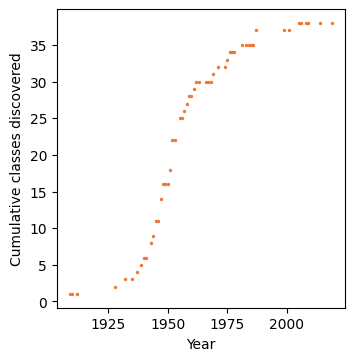

In [6]:
fig, ax = grid(panel_size=FIG_PANEL_SIZE)

ax.scatter(year_col_prefix, f'{year_col_prefix}_discovered_count', 
           data=class_summary,
           s=2.)
ax.set(xlabel='Year', ylabel='Cumulative classes discovered')

figsave(fig, f"{year_col_prefix}-vs-cumulative-discov");

### Modelling the discovery trend

The trend appears sigmoidal, with a lag, a steep infection (The Golden Age) and a plateau. Can this be modelled as the [Coupon Collector Problem](https://en.wikipedia.org/wiki/Coupon_collector%27s_problem)?

To model this trend, we can use the chain rule:

$$\frac{dD}{dt} = \frac{dD}{dm} \frac{dm}{dt}$$

The first term, $\frac{dD}{dm}$, is the rate of discovery of new classes $D$ with respect to the rate of discovery of new bioactive molecules $m$. The second term, $\frac{dm}{dt}$, is the rate of discovery of new bioactive molecules $m$ with respect to time $t$. 

The $\frac{dD}{dm}$ term can be modelled as the [Coupon Collector Problem](https://en.wikipedia.org/wiki/Coupon_collector%27s_problem):

$$\frac{dD}{dm} = \frac{k - D + 1}{k}$$

Integrating gives:

$$D(t) = (k + 1) (1 - e^{-m / k})$$

where $k$ is the effective number of classes (coupons), and $D$ is the number of classes (cpupons) already discovered.

The $\frac{dm}{dt}$ term can be modelled conservatively as a lag time $t_{lag}$ with rate close to $0$ (before large-scale discovery platforms) and then a constant rate of discovery $n$. This step-wise function can be modelled smoothly as a shifted and scaled $tanh$.

$$\frac{dm}{dt} = \frac{n}{2}(1 + \tanh{(t - t_{lag})^h})$$

Integrating gives:

$$m(t) = \frac{n}{2h} (\log \cosh(h(t_{lag} - t)) + ht - \log \cosh ht_{lag})$$


Putting it all together,

$$D(t) = (k + 1) (1 - e^{-nt / 2k} (\frac{\cosh(h(t_{lag} - t)}{\cosh ht_{lag}})^{\frac{n}{2hk}})$$

Therefore we have four parameters to fit: 
- $k$: the effective number of classes
- $n$: the asymptotic discovery rate
- $t_{lag}$: the lag in reaching the asymptotic discovery rate 
- $h$: the slope of the discovery rate step increase

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 53.96263958603102
        x: [ 3.661e+01  2.528e+00  3.221e+01  1.187e-01]
      nit: 30
      jac: [-1.431e-06 -5.722e-06  5.245e-06 -3.815e-06]
 hess_inv: [[ 2.063e-01 -3.568e-02 -1.099e-01  9.040e-05]
            [-3.568e-02  7.093e-03  1.897e-02  5.602e-05]
            [-1.099e-01  1.897e-02  5.974e-02 -9.772e-05]
            [ 9.040e-05  5.602e-05 -9.772e-05  3.097e-05]]
     nfev: 290
     njev: 58
/tmp/slurm_5266368/ipykernel_166582/3813336915.py:33: RuntimeWarning: overflow encountered in exp
  return k / (1. + (k - 1.) * np.exp(-(t - tlag) * n))
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 99.14357089705263
        x: [ 3.610e+01  1.335e-01  1.526e+01]
      nit: 31
      jac: [ 1.049e-05  2.718e-04 -1.907e-06]
 hess_inv: [[ 3.464e-02 -3.898e-04 -6.478e-02]
            [-3.898e-04  1.221e-05  2.286e-03]
            [-6.47

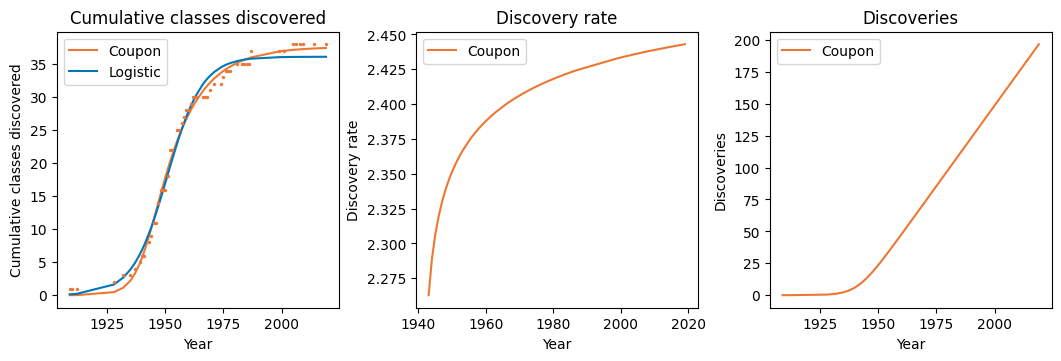

In [7]:
def discovery_rate(t, params):
    
    k, n, tlag, slope = np.split(params, 4, axis=-1)
    t = t[np.newaxis] 
    
    return (n  / 2.) * (1. + np.tanh(((t - tlag) ** slope)))


def discoveries(t, params):
    
    k, n, tlag, slope = np.split(params, 4, axis=-1)
    t = t[np.newaxis] 
    
    return (n  / (2. * slope)) * (np.log(np.cosh(slope * (tlag - t))) + slope * t - np.log(np.cosh(slope * tlag)))
    

def coupon_collector(t, params):
    
    k, n, tlag, slope = np.split(params, 4, axis=-1)
    t = t[np.newaxis]
    
    m = discoveries(t, params)
    D = (k + 1.) * (1. - np.exp(-m / k))
    
    return D


def logistic(t, params):
    
    k, n, tlag = np.split(params, 3, axis=-1)
    t = t[np.newaxis] 
    
    return k / (1. + (k - 1.) * np.exp(-(t - tlag) * n))


def loss(y_pred, y_true):
    return np.sum(np.square(y_pred - y_true))


def obj_fun(model):
    
    def _obj_fun(params):
    
        y_pred = model(class_summary['time'].values, params)
        y_true = class_summary['year_discovered_count'].values

        return loss(y_pred, y_true)
    
    return _obj_fun


# Compare coupon collector to naive logistic
coupon_collector_params = minimize(obj_fun(coupon_collector), x0=np.array([1., 1., 0., 1.])) # k, n, tlag, slope
print_err(coupon_collector_params)
logistic_params = minimize(obj_fun(logistic), x0=np.array([1., 1., 1.])) # k, n, tlag
print_err(logistic_params)

timepoints = class_summary['time'].values
coupon_pred = coupon_collector(timepoints, coupon_collector_params.x)
logistic_pred = logistic(timepoints, logistic_params.x)
discovery_rate_pred = discovery_rate(timepoints, coupon_collector_params.x)
n_discovered_pred = discoveries(timepoints, coupon_collector_params.x)

fig, axes = grid(ncol=3, 
                 panel_size=FIG_PANEL_SIZE)

for ax, data, lab in zip(axes, 
                         ((coupon_pred, logistic_pred), (discovery_rate_pred, ), (n_discovered_pred, )), 
                         ('Cumulative classes discovered', 'Discovery rate', 'Discoveries')):

    for model_name, d in zip(("Coupon", "Logistic"), data):
        ax.plot(class_summary['year'], np.squeeze(d),
                zorder=0, label=model_name)
    ax.legend()
    ax.set(title=lab, 
          xlabel='Year', ylabel=lab)

axes[0].scatter('year', 'year_discovered_count', 
                data=class_summary,
                s=2.)

figsave(fig, "discov-rate-fits");

The sum of squares for Coupon Collector is lower than for naive logistic model.

## Exploring time-to-resistance

How does the empirical distribution of time-to-resistance look? 

/camp/home/johnsoe/.conda/envs/basic/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
Saving plot as /nemo/lab/johnsone/home/users/johnsoe/projects/abx-discovery-strategy/manuscripts/2024-Parkhill-BiochemJ/nb-outputs/year-vs-ttr.png


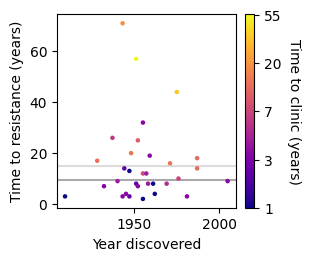

In [8]:
class_data['time_to_R'] = class_data['year_resistance'] - class_data['year_discovered']

fig, ax = grid(panel_size=2.5, aspect_ratio=1.2)

cax = ax.scatter('year_discovered', 'time_to_R', 
                 data=class_data,
                 c=np.log(class_data['year_clinic'] - class_data['year_discovered']),
                 s=5., zorder=10,
                 cmap='plasma')
cbar = fig.colorbar(cax)
cbar.ax.set_ylabel('Time to clinic (years)', rotation=-90, va="bottom")
cbar.ax.set_yticks(cbar.ax.get_yticks()[:-1], [f'{np.exp(float(t.get_text())):.0f}' for t in cbar.ax.get_yticklabels()[:-1]])
ax.axhline(np.nanmedian(class_data['time_to_R']), color='darkgrey')
ax.axhline(np.nanmean(class_data['time_to_R']), color='gainsboro')

ax.set_xlabel('Year discovered'), ax.set_ylabel('Time to resistance (years)')
figsave(fig, "year-vs-ttr");

Waiting time (such as waiting for resistance to occur) is often modelled as an exponential distribution. Does the time-to-resistance distribution fit?

/camp/home/johnsoe/.conda/envs/basic/lib/python3.11/site-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,
/camp/home/johnsoe/.conda/envs/basic/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:489: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/camp/home/johnsoe/.conda/envs/basic/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:575: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x[i] - x0[i]  # Recompute dx as exactly representable number.
/camp/home/johnsoe/.conda/envs/basic/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:489: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/camp/home/johnsoe/.conda/envs/basic/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:575: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x[i] - x0[i]  # Re

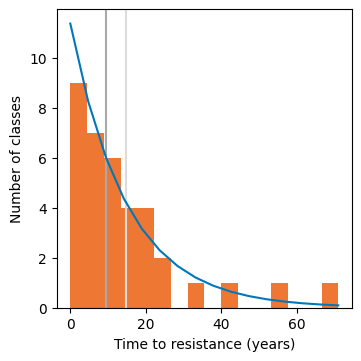

In [9]:
t2R = class_data['time_to_R'].dropna()

models = dict(exp=(lambda x, *p: expon.logpdf(x, scale=p[0]), [1. / ((t2R.size - 2.) / np.sum(t2R))]),
              gamma=(lambda x, *p: gamma.logpdf(x, a=p[0], scale=p[1]), [1., 1.]))

fits = {name: minimize(lambda p: -np.sum(model(t2R, *p)), 
                       x0=start_params, 
                       method='BFGS', 
                       hess='2-point',
                       jac=lambda x: approx_fprime(x, lambda p: -np.sum(model(t2R, *p))))
        for name, (model, start_params) in models.items()}

n_bins = 16
x_points = np.linspace(t2R.min(), t2R.max(), num=n_bins)
predicted = {name: np.exp(models[name][0](x_points, *fit.x))
             for name, fit in fits.items()}

loc_mle = np.size(t2R) / np.sum(t2R)

fig, ax = grid(panel_size=FIG_PANEL_SIZE)

n, bins, patches = ax.hist('time_to_R', 
                           data=class_data, 
                           bins=n_bins)
ax.axvline(np.nanmedian(class_data['time_to_R']), color='darkgrey')
ax.axvline(np.nanmean(class_data['time_to_R']), color='gainsboro')
ax.set(xlabel='Time to resistance (years)',
       ylabel='Number of classes')

bin_width = bins[1] - bins[0]
for name, prediction in predicted.items():
    if fits[name]['status'] == 0:
        ax.plot(x_points, 
                prediction * bin_width * class_data.shape[0],
                label=name)
        
figsave(fig, "ttr-hist")
print_err(fits)

(Text(0, 0.5, 'Observed quantiles'), Text(0.5, 0, 'Theoretical quantiles'))

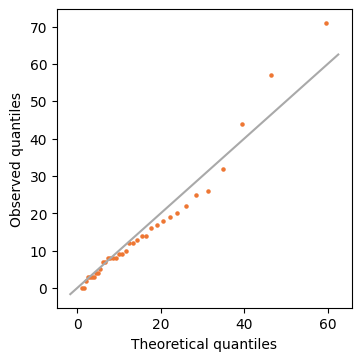

In [10]:
opt_ll = fits['exp']

fig, ax = grid(panel_size=FIG_PANEL_SIZE)
qq = probplot(t2R, (1., opt_ll.x[-1]), 
              dist='expon', fit=False)
ax.scatter(*qq, s=5.)

ax.plot(ax.get_xlim(), ax.get_xlim(), c='darkgrey')
ax.set_ylabel('Observed quantiles'), ax.set_xlabel('Theoretical quantiles')

## Number of antibiotics without detected resistance

The exponential distribution fits better than Gamma (where the algorithm fails). This suggests exponential decay of number of compounds with undetected resistance, with a half-life of around 15 years.

$\frac{dR}{dt} = \frac{D - R}{t_{1/2}}$. 

We can then model the dynamics of the number of drugs wihout detected resistance, $g$. 

$$\frac{dg}{dt} = \frac{d(D - R)}{dt}$$

Incorporating our relationships for $\frac{dD)}{dt}$ and $\frac{dR}{dt}$,

$$\frac{dg}{dt} =  \frac{k - D + 1}{k} \frac{dm}{dt} - \frac{D - R}{t_{1/2}}$$

Since,

$$\frac{dm}{dt} = \frac{n}{2}(1 + \tanh{(t - t_{lag})^h})$$

We then get:

$$\frac{dg}{dt} =  \frac{k - D + 1}{k} \frac{n}{2}(1 + \tanh{(t - t_{lag})^h}) - \frac{D - R}{t_{1/2}}$$

Since this has no closed-form integral, we will fit the model using numerical integration. Slope is fixed at $h = 1$ to minimise the number of parameters. 

In [11]:
def dg_dt(params):
    
    k, n, tlag, half_life = params
    slope = 1.
    
    def f(y, t):
        m, D, R, g = y
        
        dm = (n / 2.) * (1. + np.tanh(((t - tlag) ** slope))) 
        dD = ((k - D + 1.) / k) * dm 
        dR = (D - R) / (half_life / np.log(2.))  # Scale to half-life
        dg = dD - dR

        return [dm, dD, dR, dg]
    
    return f
    
    
def dynamic_model(t, params, y0=[1., 1., 1., 1.]):
    
    o = odeint(dg_dt(params), 
               y0=y0, 
               t=[0., t])
        
    return o[-1,:]  # -1 to take the endpoint only


def nloglik_poisson(y_pred, y_true):
    return -np.sum(poisson.logpmf(y_true, mu=y_pred))


def dobj_fun(model, df):
    
    def _dobj_fun(params):
        y_pred = [model(t, params)[1:-1] for t in df['time']]
        return nloglik_poisson(y_pred, class_summary[['year_discovered_count', 'year_resistance_count']].values)
    
    return _dobj_fun

class_summary['g'] = class_summary['year_discovered_count'] - class_summary['year_resistance_count']

function_to_minimize = dobj_fun(dynamic_model, class_summary)
initial_params = list(coupon_collector_params.x[:-1]) + [opt_ll.x[0]]
do = minimize(function_to_minimize, 
              x0=initial_params,
              jac=partial(approx_fprime, f=function_to_minimize))
print_err(do)
param_names = 'k, n, d, half_life'.split(', ')
print_err("Parameters")
print_err({name: x for name, x in zip(param_names, do.x)})
print_err("95 / 2% width")
print_err({name: 1.96 * np.sqrt(x) for name, x in zip(param_names, np.diag(do.hess_inv))})

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 246.90853021209
        x: [ 3.853e+01  1.744e+00  2.768e+01  1.211e+01]
      nit: 16
      jac: [ 0.000e+00 -2.289e-05  9.537e-06  1.907e-06]
 hess_inv: [[ 2.309e-01  6.170e-03  2.198e-01 -2.236e-01]
            [ 6.170e-03  2.265e-02  8.988e-02  1.227e-01]
            [ 2.198e-01  8.988e-02  7.295e-01  4.697e-01]
            [-2.236e-01  1.227e-01  4.697e-01  1.167e+00]]
     nfev: 26
     njev: 26
Parameters
{'k': 38.53448071501858, 'n': 1.7437155494018508, 'd': 27.68089398368423, 'half_life': 12.109590600395283}
95 / 2% width
{'k': 0.9419050448728293, 'n': 0.2949798208994313, 'd': 1.6740806590320763, 'half_life': 2.117468464493959}


Saving plot as /nemo/lab/johnsone/home/users/johnsoe/projects/abx-discovery-strategy/manuscripts/2024-Parkhill-BiochemJ/nb-outputs/resistance-curves.png


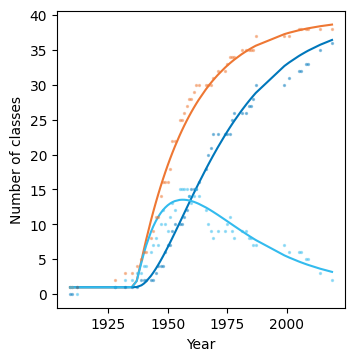

In [12]:
do_pred = np.array([dynamic_model(t, do.x) for t in class_summary['time']])

fig, ax = grid(panel_size=FIG_PANEL_SIZE)

for fit, data in zip(np.split(do_pred[:,1:], 3, axis=-1), 
                            ('year_discovered_count', 'year_resistance_count', 'g')):
    
    ax.plot(class_summary['year'], np.squeeze(fit),
            zorder=0)
    ax.scatter('year', data, 
               data=class_summary,
               s=2., alpha=.4)
        
    ax.set(xlabel='Year', ylabel='Number of classes')

figsave(fig, 'resistance-curves')

### Forecasts

What happens if we change the parameters and extrapolate into the future?

In [13]:
param_names = ('Target space', 'Maximum discovery rate', 'Discovery delay', 'Resistance rate')
named_params = dict(zip(param_names, do.x))
print_err("\n".join(f"{key}: {val}" for key, val in named_params.items()))

Target space: 38.53448071501858
Maximum discovery rate: 1.7437155494018508
Discovery delay: 27.68089398368423
Resistance rate: 12.109590600395283


fold_changes=array([1.        , 1.73205081, 3.        ])
Saving plot as /nemo/lab/johnsone/home/users/johnsoe/projects/abx-discovery-strategy/manuscripts/2024-Parkhill-BiochemJ/nb-outputs/resistance-forecasts.png


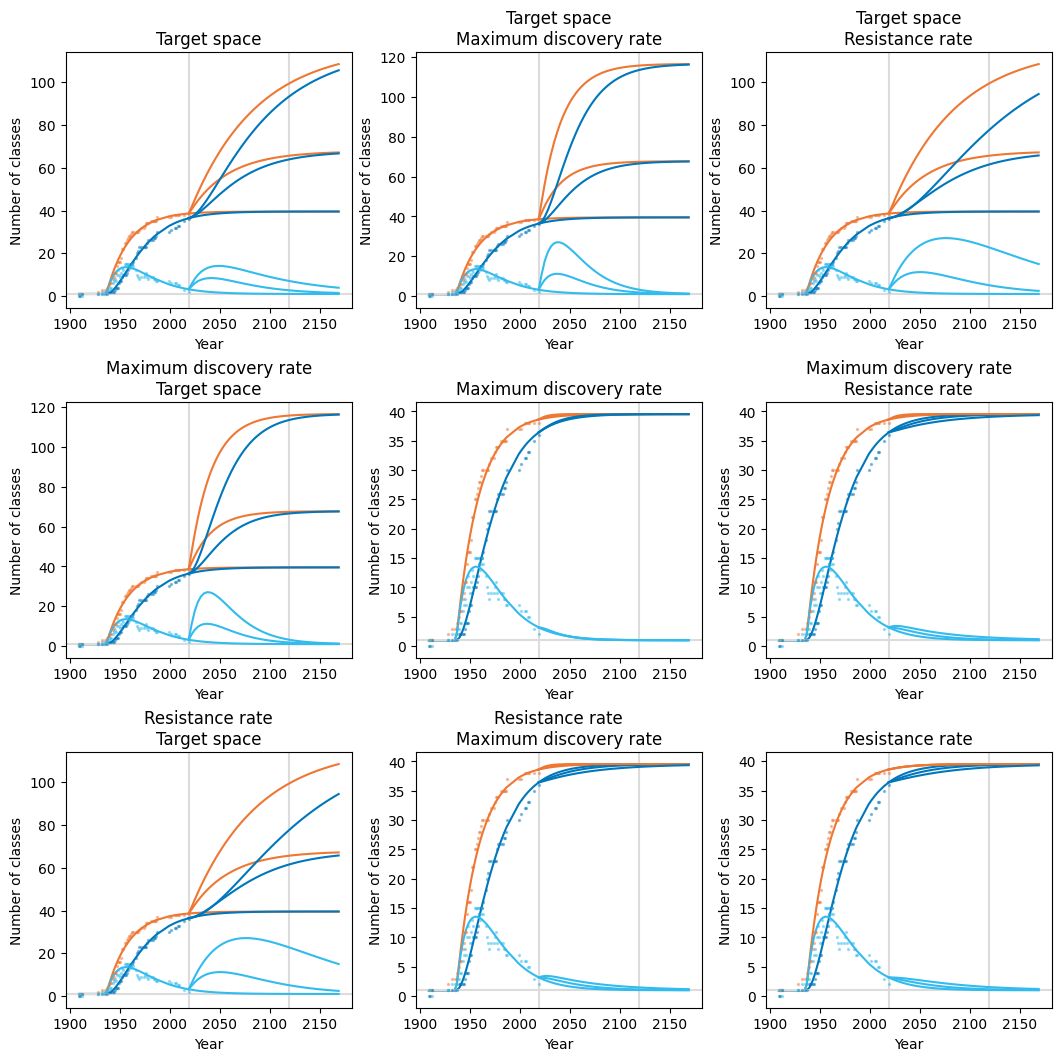

In [14]:
params_to_plot = ('Target space', 'Maximum discovery rate', 'Resistance rate')

future_t = np.linspace(0., 150., num=50)
fold_changes = np.geomspace(1., 3., num=3)

print_err(f"{fold_changes=}")

fig, axes = grid(nrow=len(params_to_plot), 
                 ncol=len(params_to_plot), 
                 panel_size=FIG_PANEL_SIZE)

for row, param_namei in zip(axes, params_to_plot):
    for ax, param_namej in zip(row, params_to_plot):
        for fit, data in zip(np.split(do_pred[:,1:], 3, axis=-1), 
                             ('year_discovered_count', 'year_resistance_count', 'g')):
            
            ax.plot(class_summary['year'], np.squeeze(fit),
                    zorder=0)
            ax.scatter('year', data, 
                       data=class_summary,
                       s=2., alpha=.4)
            
        ax.set(xlabel='Year', ylabel='Number of classes')
        ax.axhline(1., c='gainsboro', zorder=0)
        
        for i in (class_summary['year'].max(), class_summary['year'].max() + 100.):
            ax.axvline(i, c='gainsboro', zorder=0)

        if param_namei == param_namej:
            ax.set_title(param_namei)
        else:
            ax.set_title(param_namei + '\n' + param_namej)

        for xx in fold_changes:

            this_dox = named_params.copy()
            
            for n in set([param_namei, param_namej]):
                this_dox[n] *= xx
                
            this_dox['Discovery delay'] = 0.
            
            this_dox = [val for key, val in this_dox.items()]
            future_t_pred = np.array([dynamic_model(t, this_dox, y0=do_pred[-1]) 
                                      for t in future_t])

            for i, fit in enumerate(np.split(future_t_pred[:,1:], 3, axis=-1)):

                ax.plot(class_summary['year'].max() + future_t, np.squeeze(fit),
                        color=f"C{i}",
                        zorder=1)

figsave(fig, 'resistance-forecasts')